In [64]:
import metrics
import outputs
import confidence
import plot

import scipy
import csv
import mir_eval
import mirdata
import pandas as pd

import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [192]:
import imp
# imp.reload(plot)
# imp.reload(outputs)
imp.reload(confidence)

<module 'confidence' from '/Users/rachelbittner/Documents/repos/continuousf0eval/notebooks/confidence.py'>

# 5.1 Experiments - New metrics on real data

In [3]:
SKIP = [
    'ClaraBerryAndWooldog_AirTraffic_STEM_08', 'ClaraBerryAndWooldog_Stella_STEM_07'
]

def get_scores(algorithm, dataset, threshold=0.5):
    scores_new = {}
    scores_mireval = {}
    if dataset == 'ikala':
        data = mirdata.ikala.load()
    elif dataset == 'medleydb-pitch':
        data = mirdata.medleydb_pitch.load()
    else:
        raise ValueError("invalid dataset")
        
    for tid, track_data in data.items():
        if tid in SKIP:
            continue
        
        if dataset == 'ikala':
            ref_times = track_data.f0.times
            ref_freqs = track_data.f0.frequencies
            ref_conf = confidence.ikala(tid)
        else:
            ref_times = track_data.pitch.times
            ref_freqs = track_data.pitch.frequencies
            ref_conf = confidence.medleydb_pitch(tid)

        if algorithm == 'deepsalience':
            est_times, est_freqs, est_conf = outputs.load_deepsalience(outputs.DEEP_SALIENCE[tid])
        elif algorithm == 'melodia':
            est_times, est_freqs, est_conf = outputs.load_melodia(outputs.MELODIA[tid])
        elif algorithm == 'crepe':
            est_times, est_freqs, est_conf = outputs.load_crepe(outputs.CREPE[tid])
        elif algorithm == 'pyin':
            est_times, est_freqs, est_conf = outputs.load_pyin(outputs.PYIN[tid])
        else:
            raise ValueError("invalid algorithm")

        est_freqs_multiplier = np.ones(est_freqs.shape)
        est_freqs_multiplier[est_conf < threshold] = -1.0

        scores_new[tid] = metrics.evaluate(ref_times, ref_freqs, ref_conf, est_times, est_freqs, est_conf)
        scores_mireval[tid] = metrics.evaluate(
            ref_times, ref_freqs, (ref_freqs > 0).astype(float),
            est_times, est_freqs, (est_conf > threshold).astype(float))
#         scores_mireval[tid] = mir_eval.melody.evaluate(
#             ref_times, ref_freqs, est_times, est_freqs*est_freqs_multiplier)

    return scores_new, scores_mireval

In [4]:
scores_new_crepe, scores_mireval_crepe = get_scores('crepe', 'medleydb-pitch', 0.5)
scores_new_pyin, scores_mireval_pyin = get_scores('pyin', 'medleydb-pitch', 0.5)

/Users/rachelbittner/Documents/repos/continuousf0eval/notebooks/metrics.py:47: RuntimeWarning: invalid value encountered in subtract
  return np.abs(freq_diff_semitones - octave) < tolerance
/Users/rachelbittner/Documents/repos/continuousf0eval/notebooks/metrics.py:47: RuntimeWarning: invalid value encountered in less
  return np.abs(freq_diff_semitones - octave) < tolerance


In [33]:
scores_new_melodia, scores_mireval_melodia = get_scores('melodia', 'ikala', 0.5)
scores_new_deepsal, scores_mireval_deepsal = get_scores('deepsalience', 'ikala', 0.5)

In [34]:
df_new_crepe = pd.DataFrame.from_dict(scores_new_crepe, orient='index')
df_new_pyin = pd.DataFrame.from_dict(scores_new_pyin, orient='index')
df_new_deepsal = pd.DataFrame.from_dict(scores_new_deepsal, orient='index')
df_new_melodia = pd.DataFrame.from_dict(scores_new_melodia, orient='index')

df_old_crepe = pd.DataFrame.from_dict(scores_mireval_crepe, orient='index')
df_old_pyin = pd.DataFrame.from_dict(scores_mireval_pyin, orient='index')
df_old_deepsal = pd.DataFrame.from_dict(scores_mireval_deepsal, orient='index')
df_old_melodia = pd.DataFrame.from_dict(scores_mireval_melodia, orient='index')

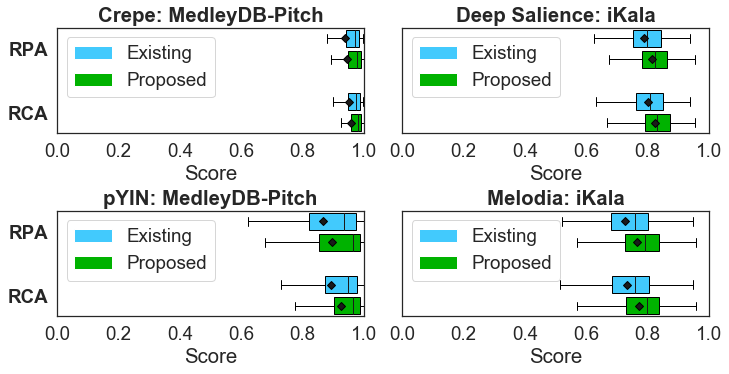

In [35]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.7)
sns.set_style('white')
# metric_vals = ["Overall Accuracy", "Raw Pitch Accuracy", "Raw Chroma Accuracy",
#            "Voicing Recall", "Voicing False Alarm"]
metric_vals = ["Raw Pitch Accuracy", "Raw Chroma Accuracy"]
metric_vals = metric_vals[::-1]

df_crepe, n_groups_crepe = plot.get_dfbox([df_new_crepe, df_old_crepe], metric_vals)
df_melodia, n_groups_melodia = plot.get_dfbox([df_new_melodia, df_old_melodia], metric_vals)
df_pyin, n_groups_pyin = plot.get_dfbox([df_new_pyin, df_old_pyin], metric_vals)
df_deepsal, n_groups_deepsal = plot.get_dfbox([df_new_deepsal, df_old_deepsal], metric_vals)

plot.add_plot(221, ['RCA', 'RPA'], df_crepe, n_groups_crepe, 'Crepe: MedleyDB-Pitch', xlim=[0.0, 1.0],
              legend_loc=0, legend_labels=['Proposed', 'Existing'])
plot.add_plot(222, metric_vals, df_deepsal, n_groups_deepsal, 'Deep Salience: iKala',
              show_yaxis=False, xlim=[0.0, 1.0],
              legend_loc=0, legend_labels=['Proposed', 'Existing'])
plot.add_plot(223, ['RCA', 'RPA'], df_pyin, n_groups_pyin, 'pYIN: MedleyDB-Pitch', xlim=[0.0, 1.0],
              legend_loc=0, legend_labels=['Proposed', 'Existing'])
plot.add_plot(224, metric_vals, df_melodia, n_groups_melodia, 'Melodia: iKala',
              show_yaxis=False, xlim=[0.0, 1.0],
              legend_loc=0, legend_labels=['Proposed', 'Existing'])
plt.tight_layout(pad=0.0, w_pad=0.1, h_pad=0.3)
plt.savefig("../paper-figs/new_vs_old_by_algorithm.pdf", fmt='pdf', bbox_inches=None)

# 5.2 Experiments - Threshold Grid

In [10]:
def get_scores_by_threshold(algorithm, dataset, binary_ref=False):
    
    scores_new = {}
    scores_mireval = {}
    thresholds = np.arange(0, 1.1, 0.1)
    for i in thresholds:
        scores_mireval[i] = {}    
    
    print(dataset)
    if dataset == 'ikala':
        data = mirdata.ikala.load()
    elif dataset == 'medleydb-pitch':
        data = mirdata.medleydb_pitch.load()
    elif dataset == 'medleydb-melody':
        data = mirdata.medleydb_melody.load()
    elif dataset == 'orchset':
        data = mirdata.orchset.load()
    else:
        raise ValueError("invalid dataset")

    for tid, track_data in data.items():
        if tid in SKIP:
            continue
        
        if dataset == 'ikala':
            ref_times = track_data.f0.times
            ref_freqs = track_data.f0.frequencies
            ref_conf = confidence.ikala(tid)
        elif dataset == 'medleydb-pitch':
            ref_times = track_data.pitch.times
            ref_freqs = track_data.pitch.frequencies
            ref_conf = confidence.medleydb_pitch(tid)
        elif dataset == 'medleydb-melody':
            ref_times = track_data.melody2.times
            ref_freqs = track_data.melody2.frequencies
            ref_conf = (ref_freqs > 0).astype(float)
        elif dataset == 'orchset':
            ref_times = track_data.melody.times
            ref_freqs = track_data.melody.frequencies
            ref_conf = (ref_freqs > 0).astype(float)

        if binary_ref:
            ref_conf = (ref_freqs > 0).astype(float)

        if algorithm == 'deepsalience':
            est_times, est_freqs, est_conf = outputs.load_deepsalience(outputs.DEEP_SALIENCE[tid])
        elif algorithm == 'melodia':
            est_times, est_freqs, est_conf = outputs.load_melodia(outputs.MELODIA[tid])
        elif algorithm == 'crepe':
            est_times, est_freqs, est_conf = outputs.load_crepe(outputs.CREPE[tid])
        elif algorithm == 'pyin':
            est_times, est_freqs, est_conf = outputs.load_pyin(outputs.PYIN[tid])
        else:
            raise ValueError("invalid algorithm")

        for i in thresholds:
            scores_mireval[i][tid] = metrics.evaluate(
                ref_times, ref_freqs, (ref_freqs > 0).astype(float),
                est_times, est_freqs, (est_conf > i).astype(float))
#             est_freqs_multiplier = np.ones(est_freqs.shape)
#             est_freqs_multiplier[est_conf < i] = -1.0
#             scores_mireval[i][tid] = mir_eval.melody.evaluate(
#                 ref_times, ref_freqs, est_times, est_freqs*est_freqs_multiplier)

        scores_new[tid] = metrics.evaluate(ref_times, ref_freqs, ref_conf, est_times, est_freqs, est_conf)

    return scores_new, scores_mireval

In [36]:
scores_new_melodia_ikala, scores_mireval_melodia_ikala = get_scores_by_threshold('melodia', 'ikala')
scores_new_deepsal_ikala, scores_mireval_deepsal_ikala = get_scores_by_threshold('deepsalience', 'ikala')

ikala
ikala


In [37]:
scores_new_melodia_ikala_bin, scores_mireval_melodia_ikala_bin = get_scores_by_threshold(
    'melodia', 'ikala', binary_ref=True)
scores_new_deepsal_ikala_bin, scores_mireval_deepsal_ikala_bin = get_scores_by_threshold(
    'deepsalience', 'ikala', binary_ref=True)

ikala
ikala


In [13]:
scores_new_melodia_mdbmel, scores_mireval_melodia_mdbmel = get_scores_by_threshold('melodia', 'medleydb-melody')
scores_new_deepsal_mdbmel, scores_mireval_deepsal_mdbmel = get_scores_by_threshold('deepsalience', 'medleydb-melody')

medleydb-melody
medleydb-melody


In [14]:
scores_new_melodia_orchset, scores_mireval_melodia_orchset = get_scores_by_threshold('melodia', 'orchset')
scores_new_deepsal_orchset, scores_mireval_deepsal_orchset = get_scores_by_threshold('deepsalience', 'orchset')

orchset
orchset


In [15]:
def comparison_matrix(scores1, scores2, metric):
    th1 = scores1.keys()
    th2 = scores2.keys()
    avg1, avg2 = {}, {}
    for th in th1:
        avg1[th] = np.average([s[metric] for s in scores1[th].values()])
    for th in th2:
        avg2[th] = np.average([s[metric] for s in scores2[th].values()])

    comparison = np.zeros((len(th1), len(th2)))
    for i, thresh1 in enumerate(sorted(th1)):
        for j, thresh2 in enumerate(sorted(th2)):
            comparison[i, j] = avg1[thresh1] - avg2[thresh2]
    return comparison, avg1, avg2

In [38]:
comp_ikala, sweep_mel_ikala, sweep_ds_ikala = comparison_matrix(
    scores_mireval_melodia_ikala, scores_mireval_deepsal_ikala, 'Overall Accuracy')
comp_mdbmel, sweep_mel_mdbmel, sweep_ds_mdbmel = comparison_matrix(
    scores_mireval_melodia_mdbmel, scores_mireval_deepsal_mdbmel, 'Overall Accuracy')
comp_orchset, sweep_mel_orchset, sweep_ds_orchset = comparison_matrix(
    scores_mireval_melodia_orchset, scores_mireval_deepsal_orchset, 'Overall Accuracy')

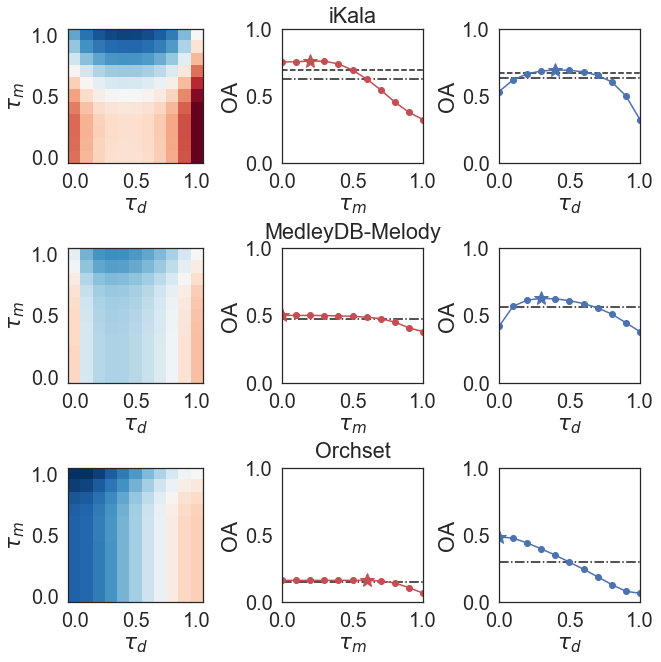

In [39]:
ticks_x = np.arange(0, 11, 5)
ticks_y = np.round(np.arange(0, 1.1, 0.1), 1)[::5]

plt.figure(figsize=(9, 9))
sns.set(font_scale=1.8)
sns.set_style('white')
plt.subplot(331)
plt.imshow(comp_ikala, origin='lower', cmap='RdBu_r', vmin=-0.4, vmax=0.4)
plt.ylabel("$τ_m$")
plt.xlabel("$τ_d$")
plt.xticks(ticks_x, ticks_y)
plt.yticks(ticks_x, ticks_y)
# plt.colorbar()

plt.subplot(332)
plt.title("iKala")
x = sorted(sweep_mel_ikala.keys())
y = [sweep_mel_ikala[i] for i in x]
v1 = np.average([t['Overall Accuracy'] for t in scores_new_melodia_ikala.values()])
v2 = np.average([t['Overall Accuracy'] for t in scores_new_melodia_ikala_bin.values()])
plt.plot([0, 1], [v1, v1], '--k')
plt.plot([0, 1], [v2, v2], '-.k')
plt.plot(x, y, '-or')
plt.plot(x[np.argmax(y)], np.max(y), '*r', markersize=15)
plt.xlabel("$τ_m$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(333)
x = sorted(sweep_ds_ikala.keys())
y = [sweep_ds_ikala[i] for i in x]
v1 = np.average([t['Overall Accuracy'] for t in scores_new_deepsal_ikala.values()])
v2 = np.average([t['Overall Accuracy'] for t in scores_new_deepsal_ikala_bin.values()])
plt.plot([0, 1], [v1, v1], '--k')
plt.plot([0, 1], [v2, v2], '-.k')
plt.plot(x, y, '-ob')
plt.plot(x[np.argmax(y)], np.max(y), '*b', markersize=15)
plt.xlabel("$τ_d$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(334)
plt.imshow(comp_mdbmel, origin='lower', cmap='RdBu_r', vmin=-0.4, vmax=0.4)
plt.ylabel("$τ_m$")
plt.xlabel("$τ_d$")
plt.xticks(ticks_x, ticks_y)
plt.yticks(ticks_x, ticks_y)
# plt.colorbar()

plt.subplot(335)
plt.title("MedleyDB-Melody", pad=10)
x = sorted(sweep_mel_mdbmel.keys())
y = [sweep_mel_mdbmel[i] for i in x]
v2 = np.average([t['Overall Accuracy'] for t in scores_new_melodia_mdbmel.values()])
plt.plot([0, 1], [v2, v2], '-.k')
plt.plot(x, y, '-or')
plt.plot(x[np.argmax(y)], np.max(y), '*r', markersize=15)
plt.xlabel("$τ_m$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(336)
x = sorted(sweep_ds_mdbmel.keys())
y = [sweep_ds_mdbmel[i] for i in x]
v2 = np.average([t['Overall Accuracy'] for t in scores_new_deepsal_mdbmel.values()])
plt.plot([0, 1], [v2, v2], '-.k')
plt.plot(x, y, '-ob')
plt.plot(x[np.argmax(y)], np.max(y), '*b', markersize=15)
plt.xlabel("$τ_d$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)


plt.subplot(337)
plt.imshow(comp_orchset, origin='lower', cmap='RdBu_r', vmin=-0.4, vmax=0.4)
plt.ylabel("$τ_m$")
plt.xlabel("$τ_d$")
plt.xticks(ticks_x, ticks_y)
plt.yticks(ticks_x, ticks_y)
# plt.colorbar()

plt.subplot(338)
plt.title("Orchset", pad=10)
x = sorted(sweep_mel_orchset.keys())
y = [sweep_mel_orchset[i] for i in x]
v2 = np.average([t['Overall Accuracy'] for t in scores_new_melodia_orchset.values()])
plt.plot([0, 1], [v2, v2], '-.k')
plt.plot(x, y, '-or')
plt.plot(x[np.argmax(y)], np.max(y), '*r', markersize=15)
plt.xlabel("$τ_m$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(339)
x = sorted(sweep_ds_orchset.keys())
y = [sweep_ds_orchset[i] for i in x]
v2 = np.average([t['Overall Accuracy'] for t in scores_new_deepsal_orchset.values()])
plt.plot([0, 1], [v2, v2], '-.k')
plt.plot(x, y, '-ob')
plt.plot(x[np.argmax(y)], np.max(y), '*b', markersize=15)
plt.xlabel("$τ_d$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.3)
plt.savefig("../paper-figs/grid_comparisons_melody.pdf", fmt='pdf', bbox_inches=None)

### threshold plots for VFA, and VR

In [28]:
_, sweep_mel_ikala_vr, sweep_ds_ikala_vr = comparison_matrix(
    scores_mireval_melodia_ikala, scores_mireval_deepsal_ikala, 'Voicing Recall')
_, sweep_mel_mdbmel_vr, sweep_ds_mdbmel_vr = comparison_matrix(
    scores_mireval_melodia_mdbmel, scores_mireval_deepsal_mdbmel, 'Voicing Recall')
_, sweep_mel_orchset_vr, sweep_ds_orchset_vr = comparison_matrix(
    scores_mireval_melodia_orchset, scores_mireval_deepsal_orchset, 'Voicing Recall')

_, sweep_mel_ikala_vfa, sweep_ds_ikala_vfa = comparison_matrix(
    scores_mireval_melodia_ikala, scores_mireval_deepsal_ikala, 'Voicing False Alarm')
_, sweep_mel_mdbmel_vfa, sweep_ds_mdbmel_vfa = comparison_matrix(
    scores_mireval_melodia_mdbmel, scores_mireval_deepsal_mdbmel, 'Voicing False Alarm')
_, sweep_mel_orchset_vfa, sweep_ds_orchset_vfa = comparison_matrix(
    scores_mireval_melodia_orchset, scores_mireval_deepsal_orchset, 'Voicing False Alarm')

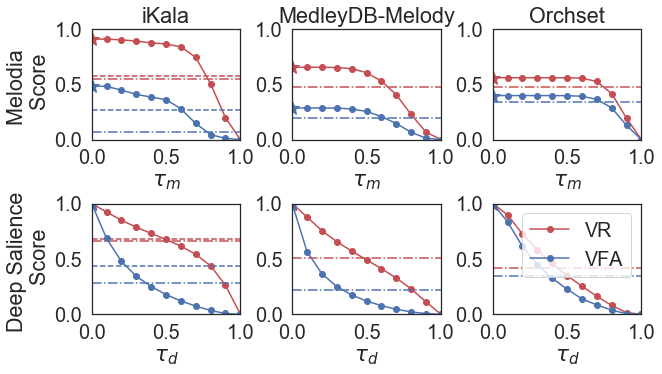

In [189]:
ticks_x = np.arange(0, 11, 5)
ticks_y = np.round(np.arange(0, 1.1, 0.1), 1)[::5]

# row is algorithm (x2, melodia, deep sal)
# col is dataset (x3, ikala, mdbmel, orchset)


plt.figure(figsize=(9, 5))
sns.set(font_scale=1.8)
sns.set_style('white')


plt.subplot(231)
# ikala, melodia
plt.title("iKala")
x1 = sorted(sweep_mel_ikala_vr.keys())
y1 = [sweep_mel_ikala_vr[i] for i in x1]
v11 = np.average([t['Voicing Recall'] for t in scores_new_melodia_ikala.values()])
v12 = np.average([t['Voicing Recall'] for t in scores_new_melodia_ikala_bin.values()])
plt.plot([0, 1], [v11, v11], '--r')
plt.plot([0, 1], [v12, v12], '-.r')
plt.plot(x1, y1, '-or')
plt.plot(x1[np.argmax(y1)], np.max(y1), '*r', markersize=15)
x2 = sorted(sweep_mel_ikala_vfa.keys())
y2 = [sweep_mel_ikala_vfa[i] for i in x2]
v21 = np.average([t['Voicing False Alarm'] for t in scores_new_melodia_ikala.values()])
v22 = np.average([t['Voicing False Alarm'] for t in scores_new_melodia_ikala_bin.values()])
plt.plot([0, 1], [v21, v21], '--b')
plt.plot([0, 1], [v22, v22], '-.b')
plt.plot(x2, y2, '-ob')
plt.plot(x2[np.argmax(y2)], np.max(y2), '*b', markersize=15)
plt.xlabel("$τ_m$")
plt.ylabel("Melodia \n Score")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(232)
# mdbmel, melodia
plt.title("MedleyDB-Melody")
x1 = sorted(sweep_mel_mdbmel_vr.keys())
y1 = [sweep_mel_mdbmel_vr[i] for i in x1]
v12 = np.average([t['Voicing Recall'] for t in scores_new_melodia_mdbmel.values()])
plt.plot([0, 1], [v12, v12], '-.r')
plt.plot(x1, y1, '-or')
plt.plot(x1[np.argmax(y1)], np.max(y1), '*r', markersize=15)
x2 = sorted(sweep_mel_mdbmel_vfa.keys())
y2 = [sweep_mel_mdbmel_vfa[i] for i in x2]
v22 = np.average([t['Voicing False Alarm'] for t in scores_new_melodia_mdbmel.values()])
plt.plot([0, 1], [v22, v22], '-.b')
plt.plot(x2, y2, '-ob')
plt.plot(x2[np.argmax(y2)], np.max(y2), '*b', markersize=15)
plt.xlabel("$τ_m$")
# plt.ylabel("Score - Melodia")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(233)
# orchset, melodia
plt.title("Orchset")
x1 = sorted(sweep_mel_orchset_vr.keys())
y1 = [sweep_mel_orchset_vr[i] for i in x1]
v12 = np.average([t['Voicing Recall'] for t in scores_new_melodia_orchset.values()])
plt.plot([0, 1], [v12, v12], '-.r')
plt.plot(x1, y1, '-or', label='VR')
plt.plot(x1[np.argmax(y1)], np.max(y1), '*r', markersize=15)
x2 = sorted(sweep_mel_orchset_vfa.keys())
y2 = [sweep_mel_orchset_vfa[i] for i in x2]
v22 = np.average([t['Voicing False Alarm'] for t in scores_new_melodia_orchset.values()])
plt.plot([0, 1], [v22, v22], '-.b')
plt.plot(x2, y2, '-ob', label='VFA')
plt.plot(x2[np.argmax(y2)], np.max(y2), '*b', markersize=15)
plt.xlabel("$τ_m$")
# plt.ylabel("Score - Melodia")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)
# plt.legend(loc=0)#, ncol=2)

plt.subplot(234)
# ikala, deepsal
# plt.title("iKala")
x1 = sorted(sweep_ds_ikala_vr.keys())
y1 = [sweep_ds_ikala_vr[i] for i in x1]
v11 = np.average([t['Voicing Recall'] for t in scores_new_deepsal_ikala.values()])
v12 = np.average([t['Voicing Recall'] for t in scores_new_deepsal_ikala_bin.values()])
plt.plot([0, 1], [v11, v11], '--r')
plt.plot([0, 1], [v12, v12], '-.r')
plt.plot(x1, y1, '-or')
plt.plot(x1[np.argmax(y1)], np.max(y1), '*r', markersize=15)
x2 = sorted(sweep_ds_ikala_vfa.keys())
y2 = [sweep_ds_ikala_vfa[i] for i in x2]
v21 = np.average([t['Voicing False Alarm'] for t in scores_new_deepsal_ikala.values()])
v22 = np.average([t['Voicing False Alarm'] for t in scores_new_deepsal_ikala_bin.values()])
plt.plot([0, 1], [v21, v21], '--b')
plt.plot([0, 1], [v22, v22], '-.b')
plt.plot(x2, y2, '-ob')
plt.plot(x2[np.argmax(y2)], np.max(y2), '*b', markersize=15)
plt.xlabel("$τ_d$")
plt.ylabel("Deep Salience \n Score")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(235)
# mdbmel, deepsal
# plt.title("MedleyDB-Melody")
x1 = sorted(sweep_ds_mdbmel_vr.keys())
y1 = [sweep_ds_mdbmel_vr[i] for i in x1]
v12 = np.average([t['Voicing Recall'] for t in scores_new_deepsal_mdbmel.values()])
plt.plot([0, 1], [v12, v12], '-.r')
plt.plot(x1, y1, '-or')
plt.plot(x1[np.argmax(y1)], np.max(y1), '*r', markersize=15)
x2 = sorted(sweep_ds_mdbmel_vfa.keys())
y2 = [sweep_ds_mdbmel_vfa[i] for i in x2]
v22 = np.average([t['Voicing False Alarm'] for t in scores_new_deepsal_mdbmel.values()])
plt.plot([0, 1], [v22, v22], '-.b')
plt.plot(x2, y2, '-ob')
plt.plot(x2[np.argmax(y2)], np.max(y2), '*b', markersize=15)
plt.xlabel("$τ_d$")
# plt.ylabel("Score - Melodia")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(236)
# orchset, deepsal
# plt.title("Orchset")
x1 = sorted(sweep_ds_orchset_vr.keys())
y1 = [sweep_ds_orchset_vr[i] for i in x1]
v12 = np.average([t['Voicing Recall'] for t in scores_new_deepsal_orchset.values()])
plt.plot([0, 1], [v12, v12], '-.r')
plt.plot(x1, y1, '-or', label='VR')
plt.plot(x1[np.argmax(y1)], np.max(y1), '*r', markersize=15)
x2 = sorted(sweep_ds_orchset_vfa.keys())
y2 = [sweep_ds_orchset_vfa[i] for i in x2]
v22 = np.average([t['Voicing False Alarm'] for t in scores_new_deepsal_orchset.values()])
plt.plot([0, 1], [v22, v22], '-.b')
plt.plot(x2, y2, '-ob', label='VFA')
plt.plot(x2[np.argmax(y2)], np.max(y2), '*b', markersize=15)
plt.xlabel("$τ_d$")
# plt.ylabel("Score - Melodia")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)
plt.legend(loc=0)

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.savefig("../paper-figs/thresh_plots_voicing.pdf", fmt='pdf', bbox_inches=None)

### Pitch

In [ ]:
scores_new_crepe, scores_mireval_crepe = get_scores_by_threshold('crepe', 'medleydb-pitch')
scores_new_pyin, scores_mireval_pyin = get_scores_by_threshold('pyin', 'medleydb-pitch')

In [ ]:
scores_new_crepe_bin, _ = get_scores_by_threshold('crepe', 'medleydb-pitch', binary_ref=True)
scores_new_pyin_bin, _ = get_scores_by_threshold('pyin', 'medleydb-pitch', binary_ref=True)

In [ ]:
comp_mdbpitch, sweep_pyin_mdbpitch, sweep_crepe_mdbpitch = comparison_matrix(
    scores_mireval_pyin, scores_mireval_crepe, 'Overall Accuracy')

comp_mdbpitch, sweep_pyin_mdbpitch, sweep_crepe_mdbpitch = comparison_matrix(
    scores_mireval_pyin, scores_mireval_crepe, 'Overall Accuracy')

In [ ]:
ticks_x = np.arange(0, 11, 5)
ticks_y = np.round(np.arange(0, 1.1, 0.1), 1)[::5]

plt.figure(figsize=(9, 3))
sns.set(font_scale=1.8)
sns.set_style('white')

plt.subplot(131)
plt.imshow(comp_mdbpitch, origin='lower', cmap='RdBu_r', vmin=-0.4, vmax=0.4)
plt.ylabel("$τ_p$")
plt.xlabel("$τ_c$")
plt.xticks(ticks_x, ticks_y)
plt.yticks(ticks_x, ticks_y)
# plt.colorbar()

plt.subplot(132)
plt.title("MedleyDB-Pitch", pad=10)
x = sorted(sweep_pyin_mdbpitch.keys())
y = [sweep_pyin_mdbpitch[i] for i in x]
v1 = np.average([t['Overall Accuracy'] for t in scores_new_pyin.values()])
v2 = np.average([t['Overall Accuracy'] for t in scores_new_pyin_bin.values()])
plt.plot([0, 1], [v1, v1], '--k')
plt.plot([0, 1], [v2, v2], '-.k')
plt.plot(x, y, '-or')
plt.plot(x[np.argmax(y)], np.max(y), '*r', markersize=15)
plt.xlabel("$τ_p$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(133)
x = sorted(sweep_crepe_mdbpitch.keys())
y = [sweep_crepe_mdbpitch[i] for i in x]
v1 = np.average([t['Overall Accuracy'] for t in scores_new_crepe.values()])
v2 = np.average([t['Overall Accuracy'] for t in scores_new_crepe_bin.values()])
plt.plot([0, 1], [v1, v1], '--k')
plt.plot([0, 1], [v2, v2], '-.k')
plt.plot(x, y, '-ob')
plt.plot(x[np.argmax(y)], np.max(y), '*b', markersize=15)
plt.xlabel("$τ_c$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.3)
plt.savefig("../paper-figs/grid_comparisons_pitch.pdf", fmt='pdf', bbox_inches=None)

# 5.4 New metric - mixed binary and continuous reference and estimate


In [ ]:
def get_mixed_results(threshold=0.5):
    scores_mireval = {}

    scores_bin_ref_bin_est = {}
    scores_bin_ref_cnt_est = {}
    scores_cnt_ref_bin_est = {}
    scores_cnt_ref_cnt_est = {}

    data = mirdata.ikala.load()

    for tid, track_data in data.items():
        if tid in SKIP:
            continue
        
        ref_times = track_data.f0.times
        ref_freqs = track_data.f0.frequencies
        ref_conf = confidence.ikala(tid)
        ref_conf_bin = (ref_freqs > 0).astype(float)

        est_times, est_freqs, est_conf = outputs.load_deepsalience(outputs.DEEP_SALIENCE[tid])
        est_conf_bin = (est_conf > threshold).astype(float)
        
        est_freqs_multiplier = np.ones(est_freqs.shape)
        est_freqs_multiplier[est_conf < threshold] = -1.0

        scores_bin_ref_bin_est[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf_bin, est_times, est_freqs, est_conf_bin)
        scores_bin_ref_cnt_est[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf_bin, est_times, est_freqs, est_conf)
        scores_cnt_ref_bin_est[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf, est_times, est_freqs, est_conf_bin)
        scores_cnt_ref_cnt_est[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf, est_times, est_freqs, est_conf)

        scores_mireval[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf_bin,
            est_times, est_freqs, est_conf_bin)
#         scores_mireval[tid] = mir_eval.melody.evaluate(
#             ref_times, ref_freqs, est_times, est_freqs*est_freqs_multiplier)

    return (scores_mireval,
            scores_bin_ref_bin_est, scores_bin_ref_cnt_est,
            scores_cnt_ref_bin_est, scores_cnt_ref_cnt_est
        )

In [ ]:
s_mireval, s_br_be, s_br_ce, s_cr_be, s_cr_ce = get_mixed_results()

In [ ]:
df_mireval = pd.DataFrame.from_dict(s_mireval, orient='index')
df_br_be = pd.DataFrame.from_dict(s_br_be, orient='index')
df_br_ce = pd.DataFrame.from_dict(s_br_ce, orient='index')
df_cr_be = pd.DataFrame.from_dict(s_cr_be, orient='index')
df_cr_ce = pd.DataFrame.from_dict(s_cr_ce, orient='index')

In [ ]:
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.4)
sns.set_style('white')
metric_vals = ["Overall Accuracy", "Raw Pitch Accuracy", "Raw Chroma Accuracy",
           "Voicing Recall", "Voicing False Alarm"]
metric_vals = metric_vals[::-1]

df_grid, n_groups_grid = plot.get_dfbox(
    [df_br_be, df_br_ce, df_cr_be, df_cr_ce], metric_vals)

plot.add_plot(111, ['OA', 'RPA', 'RCA', 'VR', 'VFA'][::-1], df_grid, n_groups_grid, '', xlim=[0.0, 1.0],
              legend_loc=0, legend_labels=[
                  'BR + BE',
                  'BR + CE',
                  'CR + BE',
                  'CR + CE'
              ], colors=sns.color_palette(n_colors=5))

plt.tight_layout()
plt.savefig("../paper-figs/binary-continuous-grid.pdf", fmt='pdf', bbox_inches=None)

# 4a - Qualitative Example of voicing disagreement with reference

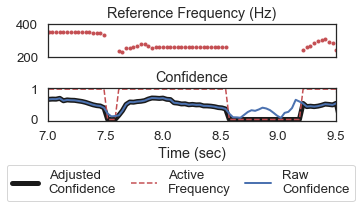

In [182]:
def temp_ikala(track_id, source_sep=False):

    if source_sep:
        confidence_fpath = os.path.join(
            "../experiments/separation_confidence",
            "iKala", "{}_VUIMM.wav.conf.csv".format(track_id))
    else:
        confidence_fpath = (
            "../experiments/confidence/iKala/{}.wav.conf.csv".format(track_id))

    with open(confidence_fpath, 'r') as fhandle:
        reader = csv.reader(fhandle, delimiter=',')
        raw_times, raw_conf = [], []

        for line in reader:
            raw_times.append(float(line[0]))
            raw_conf.append(float(line[1]))

    track_data = mirdata.ikala.load_track(track_id)

    conf = scipy.interpolate.interp1d(
        np.array(raw_times), np.array(raw_conf),
        'linear', fill_value=0.0, bounds_error=False)(track_data.f0.times)

#     conf = conf * (track_data.f0.frequencies > 0).astype('float')

    return conf

for tid in mirdata.ikala.track_ids():
    track_data = mirdata.ikala.load_track(tid)
    ref_times = track_data.f0.times
    ref_freqs = track_data.f0.frequencies
    ref_conf = temp_ikala(tid)

    fig = plt.figure(figsize=(5, 3))
    sns.set(font_scale=1.2)
    sns.set_style('white')
    ax = plt.subplot(211)
#     plt.title("Frequency")
    plt.plot(ref_times, ref_freqs, '.r')
    plt.xlim([7, 9.5])
    plt.ylim([200, 400])
    plt.xticks([], [])
    plt.title("Reference Frequency (Hz)")
    plt.subplot(212)
#     plt.title("Estimated Confidence")
    plt.plot(ref_times, ref_conf * (ref_freqs > 0).astype('float'), '-k', linewidth=5, label='Adjusted\nConfidence')
    plt.plot(ref_times, (ref_freqs > 0).astype(float), '--r', label='Active\nFrequency')
    plt.plot(ref_times, ref_conf, '-b', linewidth=2, label='Raw\nConfidence')
    plt.xlim([7, 9.5])
    plt.title("Confidence")
    plt.xlabel("Time (sec)")
    plt.tight_layout()
    
    fig.legend(ncol=3, loc=3, mode='expand')

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.4)

    plt.savefig("../paper-figs/confidence_ex.pdf", fmt='pdf', bbox_inches=None)
    break

# 4b - Compare SS confidence vs RMS confidence ikala Deep Salience

In [196]:
def get_ikala_conf_scores():

    scores_rms_conf = {}
    scores_ss_conf = {}

    data = mirdata.ikala.load()

    for tid, track_data in data.items():
        if tid in SKIP:
            continue
        
        ref_times = track_data.f0.times
        ref_freqs = track_data.f0.frequencies
        ref_conf = confidence.ikala(tid)
        ref_conf_ss = confidence.ikala(tid, source_sep=True)

        est_times, est_freqs, est_conf = outputs.load_deepsalience(outputs.DEEP_SALIENCE[tid])    

        scores_rms_conf[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf, est_times, est_freqs, est_conf)
        scores_ss_conf[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf_ss, est_times, est_freqs, est_conf)
        
    return scores_rms_conf, scores_ss_conf

In [197]:
scores_rms_conf, scores_ss_conf = get_ikala_conf_scores()

In [201]:
data = mirdata.ikala.load()
for tid, track_data in data.items():
    if tid in SKIP:
        continue

    ref_times = track_data.f0.times
    ref_freqs = track_data.f0.frequencies
    ref_conf = confidence.ikala(tid)
    ref_conf_ss = confidence.ikala(tid, source_sep=True)
    break

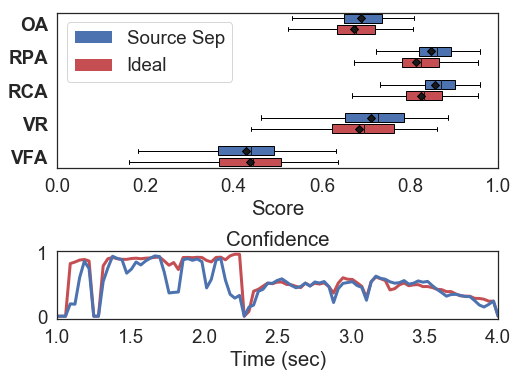

In [245]:
df_rms = pd.DataFrame.from_dict(scores_rms_conf, orient='index')
df_ss = pd.DataFrame.from_dict(scores_ss_conf, orient='index')

plt.figure(figsize=(7, 6))
sns.set(font_scale=1.7)
sns.set_style('white')
metric_vals = ["Overall Accuracy", "Raw Pitch Accuracy", "Raw Chroma Accuracy",
           "Voicing Recall", "Voicing False Alarm"]
metric_vals = metric_vals[::-1]

df_ss_exp, n_groups_ss = plot.get_dfbox([df_rms, df_ss], metric_vals)

plot.add_plot(211, ['VFA', 'VR', 'RCA', 'RPA', 'OA'], df_ss_exp, n_groups_ss,
              '', xlim=[0.0, 1.0],
              legend_loc=0, legend_labels=['Ideal', 'Source Sep'], colors=['r', 'b'])

plt.subplot(413)
plt.plot(ref_times, ref_conf, 'r', label="Ideal", linewidth=3)
plt.plot(ref_times, ref_conf_ss, 'b', label="Source Sep", linewidth=3)
plt.xlabel("Time (sec)")
plt.title("Confidence")
# plt.legend()
plt.xlim([1, 4])

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=-1)
plt.savefig("../paper-figs/ss_vs_rms.pdf", fmt='pdf', bbox_inches=None)

In [212]:
plt.figure(figsize=(5, 2))


<Figure size 360x144 with 0 Axes>

<Figure size 360x144 with 0 Axes>